# Here screenshots are assigned to the videoframes
To achive that:     
- The videos are filtered 
- The videoname and screenshotname - strings are matched using fuzzywuzzy
- The frames in Videos are found using TemplateMatching
- A JSON file is generated containing framenumber in video, matching score and imagename

## Notebook Overview 
* [Imports](#chapter0)
* [Functions](#chapter1)

* [Sort, filter and structure videos and images](#chapter2)
    * [Screenshot- and Video String Matching](#section_2_1)
    * [Demonstration of Template Matching for a examplary Video-Screenshot-Pair](#section_2_2)
    * [Generation of dict containing Video and Label Frames](#section_2_3)

* [Frame Extraction to new Folder](#chapter3)



## Imports <a class="anchor" id="chapter0"></a>

In [6]:
# Datamanipulation 
import pandas as pd
import numpy as np
import unicodedata
# Working with images
import cv2
# Path tools
import glob
import os
# Stringmatching
from fuzzywuzzy import fuzz
# Vizualization
from matplotlib import pyplot as plt
import json

/Users/marcworner/opt/anaconda3/envs/ski_extract/lib/python3.12/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### Functions <a class="anchor" id="chapter1"></a>

In [ ]:
def compare_frames_screenshot_with_matchTemplate(video_path, screenshot_path):
    """ For a given video and screenshot this function returns the frame of the video 
    with the highest simmilarity to the screenshot using openCV matchTemplate"""

    screenshot = cv2.imread(screenshot_path, cv2.IMREAD_GRAYSCALE)
    video = cv2.VideoCapture(video_path)
    highest_match_score = 0
    highscore_frame = 0

    for i in range(0,int(video.get(cv2.CAP_PROP_FRAME_COUNT))):
        video.set(cv2.CAP_PROP_POS_FRAMES, i)
        success, extracted_frame = video.read()

        if not success:
            print(f"Warning: Could not read frame {i}")
            continue
        
        extracted_frame_gray = cv2.cvtColor(extracted_frame, cv2.COLOR_BGR2GRAY)

        result = cv2.matchTemplate(extracted_frame_gray, screenshot, cv2.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

        if max_val > highest_match_score:
            highest_match_score = max_val
            highscore_frame = i

    print(f"frame number: {highscore_frame} has the highest score with:  {highest_match_score}")

    return highest_match_score, highscore_frame

def part_of_frame_check(extracted_frame, screenshot):
    result = cv2.matchTemplate(extracted_frame, screenshot, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    print(max_val)

def plot_frame(image):

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title("Image from OpenCV")
    plt.show()

def contains_umlaut_or_sharp_s(s):
    umlauts_and_sharp_s = set("äöüÄÖÜß")
    normalized_string = unicodedata.normalize("NFC", s)
    return any(char in umlauts_and_sharp_s for char in normalized_string)


## Sort, filter and structure videos and images  <a class="anchor" id="chapter2"></a>


<div class="alert alert-block alert-info"> <b>NOTE: </b>25 videos are represented two times, these have a "_lq" tag, which is done to clearly identify the low-quality version while maintaining a clear relationship to the original file. Therefore these files are excluded to avoid multiple representation of videos.</div>

In [50]:
path_to_images = "/Volumes/ThesisUSB/AVP XC Skiing Data/Skating 2-1 armswing/pictures/lateral/"
skier_images = glob.glob(path_to_images + "*.jpg") + glob.glob(path_to_images + "*.png")

path_to_videos = "/Volumes/ThesisUSB/AVP XC Skiing Data/Skating 2-1 armswing/videos/lateral/"
skier_videos = glob.glob(path_to_videos + "*.[mM][pP]4") + glob.glob(path_to_videos + "*.[mM][oO][vV]")
skier_videos = [video for video in skier_videos if "_lq" not in video] # exclude all videos containing "_lq" to avoid double videos

image_file_names = []
video_file_names = []

for image_path in skier_images:
    file_name_with_extension = os.path.basename(image_path)
    image_file_names.append(file_name_with_extension)

for video_path in skier_videos:
    file_name_with_extension = os.path.basename(video_path)
    video_file_names.append(file_name_with_extension)

### Screenshot- and Video String Matching <a id="section_2_1"></a>
- Generation of a dictionary containing video names (keys) with 5 matching label imagenames (values)

In [ ]:
videos_and_images_dict = {}

for video_string in video_file_names:
    images_per_vid_dict = {}
    for image_string in image_file_names:
        score = fuzz.ratio(video_string, image_string) # fuzzywuzzy used to compare simmilarity of strings
        images_per_vid_dict[image_string] = score
    
    top_5 = dict(sorted(images_per_vid_dict.items(), key=lambda item: item[1], reverse=True)[:5]) # build from 5 images with hightest matching score
    key_list = list(top_5.keys())

    videos_and_images_dict[video_string] = key_list

### Demonstration of Template Matching for a examplary Video-Screenshot-Pair <a id="section_2_2"></a>

frame number: 114 has the highest score with:  0.9857714176177979


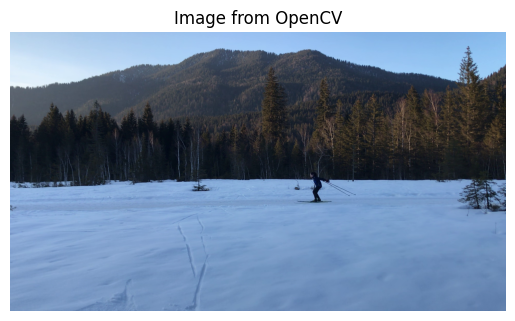

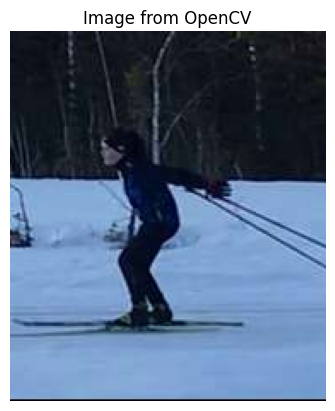

In [ ]:
path_to_example_screenshot = path_to_images + videos_and_images_dict['Grüner Amelie.MOV'][1]
path_to_frame = path_to_videos + "Grüner Amelie.MOV"

example_score, example_frame = compare_frames_screenshot_with_matchTemplate(path_to_frame, path_to_example_screenshot)
screenshot = cv2.imread(path_to_example_screenshot, cv2.IMREAD_COLOR)
test_cap = cv2.VideoCapture(path_to_frame)
test_cap.set(cv2.CAP_PROP_POS_FRAMES, example_frame)
ret, extracted_frame = test_cap.read()

plot_frame(extracted_frame)
plot_frame(screenshot)

### Generation of dict containing Video and Label Frames <a id="section_2_3"></a>
- Iteration over videos_and_images_dict to find the highscoreframe
- Afterwards this information is stored in a JSON file 

In [ ]:
label_frames_dict = {
    "videos": []
}

for key, value in videos_and_images_dict.items():

    single_video_dict = {
        "videoname": key,
        "frame_details": []
    }

    for screenshot in range(len(value)):
        
        frame_detail_dict = {}

        path_to_frame = path_to_videos + key
        path_to_screenshot = path_to_images + videos_and_images_dict[key][screenshot]
        
        highest_match_score, highscore_frame = compare_frames_screenshot_with_matchTemplate(path_to_frame, path_to_screenshot)
        frame_detail_dict["frame_number"] = highscore_frame
        frame_detail_dict["score"] = highest_match_score
        frame_detail_dict["image_name"] = videos_and_images_dict[key][screenshot]

        single_video_dict["frame_details"].append(frame_detail_dict)
    
    label_frames_dict["videos"].append(single_video_dict)

# if not exists ergänzen

with open("LabelFrames.json", "w", encoding="utf-8") as json_file:
    json.dump(label_frames_dict, json_file, indent=4, ensure_ascii=False)

## Frame Extraction to new Folder <a class="anchor" id="chapter3"></a>

In [9]:
json_test_data_path = "/Users/marcworner/Documents/University/Thesis/SkiExtract/LabelFrames.json" # path to a above generated json file

with open(json_test_data_path, 'r') as file:
    json_test_data = json.load(file)

df = pd.json_normalize(
    json_test_data['videos'], 
    record_path='frame_details', 
    meta=['videoname'], 
    sep='_'
)

df

,frame_number,score,image_name,videoname
0,142,0.985977,Klauser Hannes_004.jpg,Klauser Hannes.mp4
1,142,0.985977,Klauser Hannes_005.jpg,Klauser Hannes.mp4
2,142,0.985977,Klauser Hannes_001.jpg,Klauser Hannes.mp4
3,142,0.985977,Klauser Hannes_002.jpg,Klauser Hannes.mp4
4,142,0.985977,Klauser Hannes_003.jpg,Klauser Hannes.mp4
...,...,...,...,...
150,142,0.985977,Uhlig Niklas_003.jpg,Uhlig Niklas.MOV
151,142,0.985977,Uhlig Niklas_002.jpg,Uhlig Niklas.MOV
152,142,0.985977,Uhlig Niklas_001.jpg,Uhlig Niklas.MOV
153,142,0.985977,Uhlig Niklas_005.jpg,Uhlig Niklas.MOV


In [ ]:
output_directory = "/Volumes/ThesisUSB/AVP XC Skiing Data/Skating 2-1 armswing/"

os.makedirs(output_directory, exist_ok=True)

for i in range(len(df)):
    if df["score"][i] != 0:
        current_frame = df["frame_number"][i]
        current_video = path_to_videos + df["videoname"][i]
        current_image_name = df["image_name"][i]
        filename_without_extension = os.path.splitext(current_image_name)[0]

        output_frame_path = os.path.join(output_directory, f"{filename_without_extension}.jpg")

        cap = cv2.VideoCapture(current_video)
        cap.set(cv2.CAP_PROP_POS_FRAMES, current_frame)
        ret, extracted_frame = cap.read()

        if ret:
            # Save the extracted frame
            cv2.imwrite(output_frame_path, extracted_frame)
            print(f"Saved: {output_frame_path}")
        else:
            print(f"Failed to extract frame {current_frame} from {current_video}")

        cap.release()

